In [1]:
import networkx as nx
import numpy as np
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas
from collections import Counter
import os

In [2]:
import biograph
import numpy as np
import pandas
import networkx as nx
import matplotlib.pyplot as plt

from biograph import graphplot
from biograph import hmrf_estimator
from biograph import probability_field_hmrf_estimator

import graphsonchip
import graphsonchip.analyse

from graphsonchip.graphmaker import make_spheroids
from graphsonchip.graphmaker import graph_generation_func

In [51]:
example_prop_frame = pandas.read_csv('C:\\Users\\bonne\\BioGraph\\Examples\\Examples_prop_210216_4_individual_tile_1.csv')
#example_prop_frame = pandas.read_csv('210303_18_cut_basic.csv')

loc = example_prop_frame[(example_prop_frame.x < 1500) & 
           (example_prop_frame.y < 1500) & 
           (example_prop_frame.z > 0) & 
           (example_prop_frame.z < 50)]

descriptors = ['label', 'cell_type', 'color']
n_colors = len(loc.cell_type.unique())

In [52]:
loc = loc.drop(columns = 'Unnamed: 0').drop(columns = 'Unnamed: 0.1')
loc.index = np.arange(len(loc))
loc['label'] = loc.index

In [53]:
loc['cell_type'] = loc.cell_type.values.astype(int)

color_list = [plt.cm.Set3(i) for i in range(n_colors)]
colors = [color_list[loc.loc[i, 'cell_type']] for i in range(len(loc))]

loc['color'] = colors

#legend_list = ['CD45+, dividing', 'CD45-, dividing', 'CD45+, not dividing', 'CD45-, not dividing']
#loc['legend'] = [legend_list[loc.loc[i, 'cell_type']] for i in range(len(loc))]

spheroid = make_spheroids.single_spheroid_process(loc,
                                       cell_descriptors = descriptors)

G = graph_generation_func.generate_voronoi_graph(spheroid, cell_descriptors = descriptors, dCells = 50)

In [54]:
color_list = [plt.cm.Set3(i) for i in range(n_colors)]
cell_class = nx.get_node_attributes(G, 'cell_type')

for node in G.nodes:    
    nx.set_node_attributes(G, {node:color_list[cell_class[node]]}, 'color')
    nx.set_node_attributes(G, {node:cell_class[node]}, 'legend')

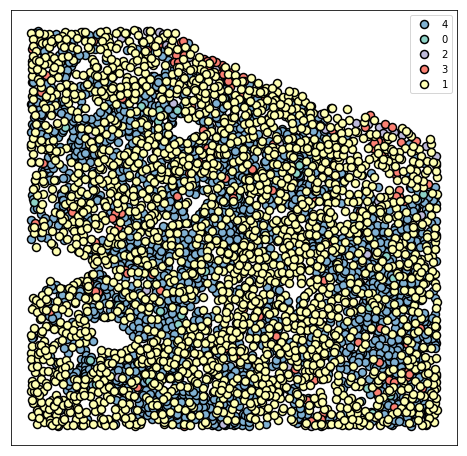

In [55]:
graphplot.scatter_plot_2D(G, 
                scatterpoint_size = 8,
                alpha_line = 0.1,
                legend = True,
                figsize = (8,8))

In [56]:
biograph = probability_field_hmrf_estimator.hmrf(G, epochs = 30, gamma = 0.4, K = 6)

In [57]:
biograph.initiate_latent_probability_field()

100%|███████████████████████████████████████████████████████████████████████████| 5015/5015 [00:00<00:00, 19334.90it/s]


In [58]:
def get_latent_probability_field_properties(G, number_of_cell_types):

    resultframe = pandas.DataFrame()
    i = 0
    
    latent_probability_field = nx.get_node_attributes(G, 'latent_probability_field')

    for node in sorted(G.nodes):
                
        for k in range(number_of_cell_types):
            resultframe.loc[i, k] = latent_probability_field[node][k]
            
        i += 1

    return resultframe.fillna(0)

In [59]:
latent_probability_field_properties = get_latent_probability_field_properties(biograph.graph, 
                                biograph.number_of_cell_types)

n_rows, n_cols = latent_probability_field_properties.shape
G = biograph.graph

X = latent_probability_field_properties.values.reshape(-1,n_cols)
X = preprocessing.StandardScaler().fit_transform(X)

In [60]:
# Apply kmeans algorithm to initiate
K = 4
kmeans = KMeans(n_clusters=K, random_state=0).fit(X)

In [61]:
color_list = [plt.cm.Set3(i) for i in range(K)]

In [62]:
for node in sorted(G.nodes):
            nx.set_node_attributes(G, {node:kmeans.labels_[node]}, 'class')
            nx.set_node_attributes(G, {node:color_list[kmeans.labels_[node]]}, 'color')
            nx.set_node_attributes(G, {node:kmeans.labels_[node]}, 'legend')

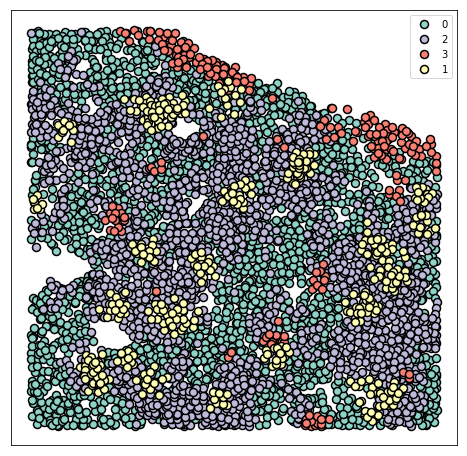

In [63]:
graphplot.scatter_plot_2D(G, 
                scatterpoint_size = 8,
                alpha_line = 0.1,
                legend = True,
                figsize = (8,8))

In [64]:
def categorical_vector(G, category):
    
    cat = nx.get_node_attributes(G, category)
    type_of_data = type(cat[0])
    V = np.array(list(cat.items()), dtype=type_of_data)
    a = map(int, V[:,0])
    a = np.array(list(a))
    ind = np.argsort(a)
    Vect = V[:,1][ind]
    
    return Vect

# For a categorical variable, convert vector from graph_to_numpy
# into a vector with 1 at positions for the desired value of the 
# category and 0 elsewhere

def desired_category_value(G, category, desired_value):
    
    Vect = categorical_vector(G, category)
    
    return np.multiply(Vect == desired_value, 1)

In [65]:
# initialisation
mu = []
cov = []
cl = categorical_vector(G, 'class')
ct = categorical_vector(G, 'cell_type')
for j in range(K):
    cell_type_j = ct[cl == j]
    mu.append(np.mean(cell_type_j))
    cov.append(np.cov(cell_type_j))

In [66]:
beta = 0.0001

In [19]:
# Expectation step

cell_class_dict = nx.get_node_attributes(G, 'class')

P_neigh = np.zeros((len(G.nodes), K))

for node in tqdm(G.nodes):

    neighbour_cell_class = [cell_class_dict[n] for n in G.neighbors(node)]
    neighbour_cell_class_counter = Counter(neighbour_cell_class)

    for cell_class in neighbour_cell_class_counter.keys():
        
        for k in range(K):
            P_neigh[node, k] += beta*int(k == cell_class)*neighbour_cell_class_counter[cell_class]

100%|███████████████████████████████████████████████████████████████████████████| 5015/5015 [00:00<00:00, 17399.29it/s]


In [21]:
P_gauss = np.zeros((len(G.nodes), K))

cell_type_dict = nx.get_node_attributes(G, 'cell_type')

for node in tqdm(G.nodes):
    
    x = cell_type_dict[node]
    
    for j in range(K):
        pref = -0.5*np.log(2*np.pi*cov[j])

        P_gauss[node, j] = pref -0.5*((x-mu[j])**2)/cov[j]

100%|███████████████████████████████████████████████████████████████████████████| 5015/5015 [00:00<00:00, 15595.51it/s]


In [22]:
# calculate product proba

prod_proba = P_gauss + P_neigh

# calculate gamma proba

gamma = np.zeros((len(G.nodes), K))

for j in range(K):
    gamma[:, j] = prod_proba[:, j]/np.sum(prod_proba,1)

In [23]:
# Maximization step
new_class = np.argmax(gamma, axis=1)

for node in sorted(G.nodes):
    nx.set_node_attributes(G, {node:new_class[node]}, 'class')
    nx.set_node_attributes(G, {node:color_list[new_class[node]]}, 'color')
    nx.set_node_attributes(G, {node:new_class[node]}, 'legend')

In [24]:
# Estimate new parameters
n = np.sum(gamma, axis = 0)

new_mu = np.dot(gamma.T, ct)/n

new_cov = np.zeros(K)
for j in range(K):
    for i in range(len(ct)):
        new_cov[j] += gamma[i, j]*((ct[i]-mu[j])**2)
new_cov /= n

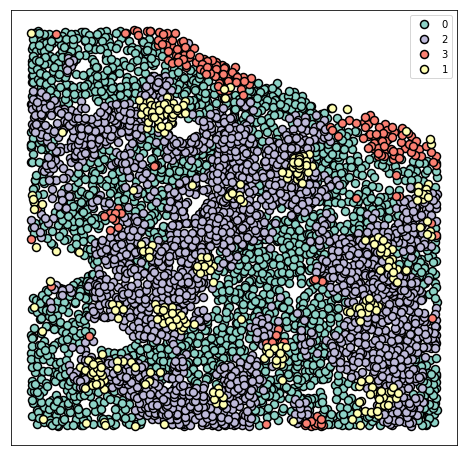

In [26]:
graphplot.scatter_plot_2D(G, 
                scatterpoint_size = 8,
                alpha_line = 0.1,
                legend = True,
                figsize = (8,8))

In [27]:
# Stopping criteria
stopcrit_mu = np.max(np.abs(new_mu - mu))/(1 + np.max([new_mu, mu]))
print(stopcrit_mu)

stopcrit_cov = np.max(new_cov - cov)/(1 + np.max([new_cov, cov]))

0.38444193805716864


# Make a loop

In [67]:
for q in range(10):
    print(q)

    # Expectation step

    cell_class_dict = nx.get_node_attributes(G, 'class')

    P_neigh = np.zeros((len(G.nodes), K))

    for node in G.nodes:

        neighbour_cell_class = [cell_class_dict[n] for n in G.neighbors(node)]
        neighbour_cell_class_counter = Counter(neighbour_cell_class)

        for cell_class in neighbour_cell_class_counter.keys():

            for k in range(K):
                P_neigh[node, k] += beta*int(k == cell_class)*neighbour_cell_class_counter[cell_class]

    P_gauss = np.zeros((len(G.nodes), K))

    cell_type_dict = nx.get_node_attributes(G, 'cell_type')

    for node in G.nodes:

        x = cell_type_dict[node]

        for j in range(K):
            pref = -0.5*np.log(2*np.pi*cov[j])

            P_gauss[node, j] = pref -0.5*((x-mu[j])**2)/cov[j]

    # calculate product proba

    prod_proba = P_gauss + P_neigh

    # calculate gamma proba

    gamma = np.zeros((len(G.nodes), K))

    for j in range(K):
        gamma[:, j] = prod_proba[:, j]/np.sum(prod_proba,1)

    # Maximization step
    new_class = np.argmax(gamma, axis=1)

    for node in sorted(G.nodes):
        nx.set_node_attributes(G, {node:new_class[node]}, 'class')
        nx.set_node_attributes(G, {node:color_list[new_class[node]]}, 'color')
        nx.set_node_attributes(G, {node:new_class[node]}, 'legend')

    # Estimate new parameters
    n = np.sum(gamma, axis = 0)

    new_mu = np.dot(gamma.T, ct)/n

    new_cov = np.zeros(K)
    for j in range(K):
        for i in range(len(ct)):
            new_cov[j] += gamma[i, j]*((ct[i]-mu[j])**2)
    new_cov /= n

    mu = new_mu
    cov = new_cov

0
1
2
3
4
5
6
7
8
9


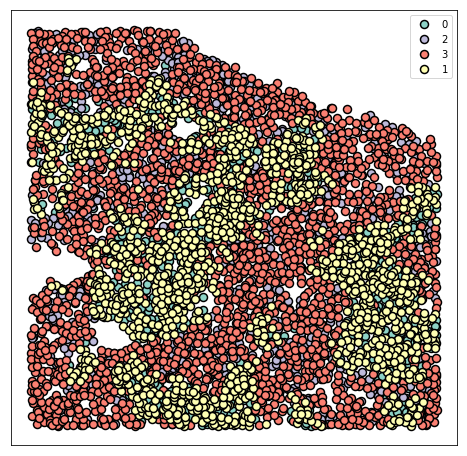

In [68]:
graphplot.scatter_plot_2D(G, 
                scatterpoint_size = 8,
                alpha_line = 0.1,
                legend = True,
                figsize = (8,8))

In [297]:
beta = 18390540191924.652

In [298]:
# Expectation step

cell_class_dict = nx.get_node_attributes(G, 'class')

log_P_neigh = np.zeros((len(G.nodes), K))

for node in G.nodes:

    neighbour_cell_class = [cell_class_dict[n] for n in G.neighbors(node)]
    neighbour_cell_class_counter = Counter(neighbour_cell_class)

    for cell_class in neighbour_cell_class_counter.keys():

        for k in range(K):
            log_P_neigh[node, k] += beta*int(k == cell_class)*neighbour_cell_class_counter[cell_class]

In [251]:
# Create matrix from cell type
cell_type_list = categorical_vector(G, 'cell_type')

# Number of cells
N = len(cell_type_list)

# Number of cell types
T = len(np.unique(cell_type_list))

mat_cell_type = np.zeros((N, T))
for i in range(N):
    mat_cell_type[i, cell_type_list[i]] = 1

In [252]:
cell_class_list = categorical_vector(G, 'class')

# Number of cell classes
classes, card_classes = np.unique(cell_class_list, return_counts=True)
K = len(classes)

# Count frequencies of cell types in each latent class
freq = np.zeros((K, T)) + 1e-4

for j in range(K):
    x1, x2 = np.unique(cell_type_list[cell_class_list == j], return_counts=True)
    freq[j, x1] = x2
    freq[j, :] /= card_classes[j]
    freq[j, :] /= np.sum(freq[j, :])

In [253]:
# PairWise correlations
Mat = []

for j in range(K):
    cells_in_class_j = mat_cell_type[cell_class_list == j]

    Matj = np.zeros((T, T))

    for m1 in range(T):
        
        for m2 in range(T):
            Matj[m1, m2] = np.sum(np.outer(cells_in_class_j[:, m1], cells_in_class_j[:, m2]))
            
        Matj[m1,m1] += 1e-8
            

    #Matj /= (card_classes[j]**2)
    Matj /= np.sum(Matj)

    Mat.append(Matj)

# test np.sum(Mat, 0) == freq[j] => OK
j = 0
print(np.sum(Mat[j], 0))
print(freq[j])

[2.86225403e-02 9.35599284e-01 3.57781753e-02 3.20019457e-14
 3.20019457e-14]
[2.86225300e-02 9.35598950e-01 3.57781625e-02 1.78890813e-07
 1.78890813e-07]


In [254]:
# Correlation matrix

C = []

for j in range(K):
    C.append(np.linalg.inv(Mat[j]-np.outer(freq[j], freq[j])))

In [286]:
log_P_gauss = np.zeros((len(G.nodes), K))

cell_type_list = categorical_vector(G, 'cell_type')

In [287]:
for j in range(K):
    for i in range(N):
        xi = mat_cell_type[i]
        log_P_gauss[i, j] = np.dot((xi - freq[j]), np.dot(C[j],(xi - freq[j]).T))

In [301]:
# calculate product proba

sum_prob = log_P_gauss + log_P_neigh

# calculate gamma proba

gamma = np.zeros((len(G.nodes), K))

for j in range(K):
    gamma[:, j] = sum_prob[:, j]/np.sum(sum_prob,1)

# Maximization step
new_class = np.argmax(gamma, axis=1)

In [302]:
for node in sorted(G.nodes):
    nx.set_node_attributes(G, {node:new_class[node]}, 'class')
    nx.set_node_attributes(G, {node:color_list[new_class[node]]}, 'color')
    nx.set_node_attributes(G, {node:new_class[node]}, 'legend')

In [ ]:
# Estimate new parameters
n = np.sum(gamma, axis = 0)

new_mu = np.dot(gamma.T, ct)/n

new_cov = np.zeros(K)
for j in range(K):
    for i in range(len(ct)):
        new_cov[j] += gamma[i, j]*((ct[i]-mu[j])**2)
new_cov /= n

mu = new_mu
cov = new_cov

# New version

In [240]:
# Expectation step

cell_class_dict = nx.get_node_attributes(G, 'class')

P_neigh = np.zeros((len(G.nodes), K))

for node in G.nodes:

    neighbour_cell_class = [cell_class_dict[n] for n in G.neighbors(node)]
    neighbour_cell_class_counter = Counter(neighbour_cell_class)

    for cell_class in neighbour_cell_class_counter.keys():

        for k in range(K):
            P_neigh[node, k] += beta*int(k == cell_class)*neighbour_cell_class_counter[cell_class]

In [241]:
# Create matrix from cell type
cell_type_list = categorical_vector(G, 'cell_type')

# Number of cells
N = len(cell_type_list)

# Number of cell types
T = len(np.unique(cell_type_list))

mat_cell_type = np.zeros((N, T))
for i in range(N):
    mat_cell_type[i, cell_type_list[i]] = 1

In [242]:
cell_class_list = categorical_vector(G, 'class')

# Number of cell classes
classes, card_classes = np.unique(cell_class_list, return_counts=True)
K = len(classes)

# Count frequencies of cell types in each latent class
freq = np.zeros((K, T))

for j in range(K):
    x1, x2 = np.unique(cell_type_list[cell_class_list == j], return_counts=True)
    freq[j, x1] = x2
    freq[j, :] /= card_classes[j]

In [ ]:
# PairWise correlations
Mat = []

for j in range(K):
    cells_in_class_j = mat_cell_type[cell_class_list == j]

    Matj = np.zeros((T, T))

    for m1 in range(T):
        
        for m2 in range(T):
            Matj[m1, m2] = np.sum(np.outer(cells_in_class_j[:, m1], cells_in_class_j[:, m2]))
            
        #Matj[m1,m1] += 1e-8
            

    #Matj /= (card_classes[j]**2)
    Matj /= np.sum(Matj)

    Mat.append(Matj)

# test np.sum(Mat, 0) == freq[j] => OK
j = 0
print(np.sum(Mat[j], 0))
print(freq[j])

In [ ]:
#Pseudocount alfa=0.5
alfa=0.5;
pa=(1-alfa)*p+alfa/21.
p2a=(1-alfa)*p2+alfa/(21*21)
#Fix the conservation constraints in the diagonal blocks
for i in range (L):
    p2a[i*q:(i+1)*q,i*q:(i+1)*q]=0
    for a in range (q):
        p2a[i*q+a,i*q+a]=pa[i*q+a]
#Regularized connected correlation matrix
cra=p2a-np.outer(pa,pa)